In [52]:
pip install -U "jax[cuda12]"

In [53]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import cupy as cp
import pandas as pd
from jax import random
import matplotlib.pyplot as plt
import time

In [54]:
gpu = cp.cuda.Device()
print("GPU ID:", gpu.id)
print("GPU name:", cp.cuda.runtime.getDeviceProperties(gpu.id)['name'])

GPU ID: 0
GPU name: b'Tesla T4'


In [55]:

def lnorm_cp(x, eps=1e-5):
    mean = cp.mean(x, axis=0, keepdims=True)
    var = cp.var(x, axis=0, keepdims=True)
    return (x - mean) / cp.sqrt(var + eps)


def gelu_cp(x):
    return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / cp.pi) * (x + 0.044715 * x**3)))


def softmax_cp(x, mask=None):
    if mask is not None:
        x = cp.where(mask, x, -1e9)
    x_max = cp.max(x, axis=0, keepdims=True)
    e_x = cp.exp(x - x_max)
    return e_x / cp.sum(e_x, axis=0, keepdims=True)

def causal_mask_cp(seq_len):
    return cp.tri(seq_len, seq_len, dtype=bool)


def matmul_cp(a, b):
    a=a.astype(cp.int32)
    b=b.astype(cp.int32)
    c = a @ b
    return cp.clip(c, -128, 127).astype(cp.int8)


def attention_per_head_decoder_cp(K, Q, V, l_total, ddh, b, h):

    lb = l_total * b
    E2 = cp.zeros((K.shape[0], lb), dtype=cp.int32)
    mask = causal_mask_cp(l_total)

    for j in range(b):
        for i in range(h):
            indJ = j * l_total
            indI2 = i * ddh

            K_slice = K[indI2:indI2+ddh, indJ:indJ+l_total].astype(cp.int32)
            Q_slice = Q[indI2:indI2+ddh, indJ:indJ+l_total].astype(cp.int32)

            E1 = K_slice.T @ Q_slice
            E1 = E1 / cp.sqrt(ddh)
            E1 = softmax_cp(E1, mask=mask)

            V_slice = V[indI2:indI2+ddh, indJ:indJ+l_total].astype(cp.int32)
            result = V_slice @ E1
            E2[indI2:indI2+ddh, indJ:indJ+l_total] = result.astype(cp.float32)

    return cp.clip(E2, -128, 127).astype(cp.int8)


def ffn_forward_cp(W1, W2, AO):
    W1=W1.astype(cp.int32)
    W2=W2.astype(cp.int32)
    AO=AO.astype(cp.int32)
    E3b = W1 @ AO
    E3 = gelu_cp(E3b)
    EOb = W2 @ E3
    EO = lnorm_cp(EOb + AO)
    return cp.clip(EO, -128, 127).astype(cp.int8)

def mha_output_cp(WO, E2, EI):
    WO=WO.astype(cp.int32)
    E2=E2.astype(cp.int32)
    AO = EI + WO @ E2
    AO= lnorm_cp(AO)
    return cp.clip(AO, -128, 127).astype(cp.int8)


b =
l = 1
d = 1280
h = 20


f = 5120
ddh = d // h
lb = b * l



In [56]:

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))

def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)


def causal_mask_jax(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len), dtype=bool))


def softmax_jax(x, mask=None, axis=-1):
    if mask is not None:
        x = jnp.where(mask, x, -1e9)
    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)


def matmul_jax(a, b):
    a= a.astype(jnp.int32)
    b= b.astype(jnp.int32)
    c = a @ b
    return jnp.clip(c, -128, 127).astype(jnp.int8)



def attention_per_head_decoder_jax(K, Q, V, l_total, ddh, b, h):
    K= K.astype(jnp.int32)
    Q= Q.astype(jnp.int32)
    V= V.astype(jnp.int32)
    lb = l_total * b
    d = K.shape[0]
    E2_init = jnp.zeros((d, lb), dtype=jnp.int32)
    mask = causal_mask_jax(l_total)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j * l_total
        indI2 = i * ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)

        scores = K_slice.T @ Q_slice / jnp.sqrt(ddh)
        E1 = softmax_jax(scores, mask=mask, axis=0)

        result = V_slice @ E1
        result_int8 = jnp.clip(result, -128, 127).astype(jnp.int8)
        E2 = lax.dynamic_update_slice(E2, result_int8, (indI2, indJ))
        return E2, None
    E2_init = jnp.zeros((d, lb), dtype=jnp.int8)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)
    return E2


def mha_output_jax(WO, E2, EI):
    E2 = E2.astype(jnp.int32)
    EI = EI.astype(jnp.int32)
    WO = WO.astype(jnp.int32)
    AO = WO @ E2 + EI
    AO = lnorm_jax(AO)
    return jnp.clip(AO, -128, 127).astype(jnp.int8)


def ffn_forward_jax(W1, W2, AO):
    AO = AO.astype(jnp.int32)
    W1 = W1.astype(jnp.int32)
    W2 = W2.astype(jnp.int32)
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3
    EO = lnorm_jax(EOb + AO)
    return jnp.clip(EO, -128, 127).astype(jnp.int8)




In [57]:


key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)


EI = jax.random.randint(keys[0], (d, lb), minval=-128, maxval=128, dtype=jnp.int8)
WQ = jax.random.randint(keys[1], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WK = jax.random.randint(keys[2], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WV = jax.random.randint(keys[3], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WO = jax.random.randint(keys[4], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
W1 = jax.random.randint(keys[5], (f, d), minval=-128, maxval=128, dtype=jnp.int8)
W2 = jax.random.randint(keys[6], (d, f), minval=-128, maxval=128, dtype=jnp.int8)


In [58]:
jax.config.update('jax_default_matmul_precision', 'highest')

In [59]:
EI_cp = cp.zeros( (d, lb),  dtype=cp.int32)
WQ_cp = cp.zeros( (d, d), dtype=cp.int32)
WK_cp = cp.zeros( (d, d),  dtype=cp.int32)
WV_cp = cp.zeros((d, d),  dtype=cp.int32)
WO_cp = cp.zeros( (d, d),  dtype=cp.int32)
W1_cp = cp.zeros( (f, d),  dtype=cp.int32)
W2_cp = cp.zeros((d, f),dtype=cp.int32)
results={}

In [60]:

results = {"CuPy": {}}


start = time.time()
Qc = matmul_cp(WQ_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_Q"] = end - start


start = time.time()
Kc = matmul_cp(WK_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_cp(WV_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_V"] = end - start


start = time.time()
E2n = attention_per_head_decoder_cp(Kc, Qc, Vc, l, ddh, b, h)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["attention"] = end - start

start = time.time()
AOc = mha_output_cp(WO_cp, E2n, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["mha_output"] = end - start


start = time.time()
EOc = ffn_forward_cp(W1_cp, W2_cp, AOc)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["ffn"] = end - start


results["CuPy"]["total"] = sum(results["CuPy"].values())
print(results["CuPy"])


{'matmul_Q': 0.0034151077270507812, 'matmul_K': 0.0032148361206054688, 'matmul_V': 0.0032906532287597656, 'attention': 2.127561569213867, 'mha_output': 0.4332730770111084, 'ffn': 0.2978692054748535, 'total': 2.868624448776245}


In [61]:
# JAX without JIT
results["JAX"] = {}


start = time.time()
Qj = matmul_jax(WQ, EI).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

# K
start = time.time()
Kj = matmul_jax(WK, EI).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

# V
start = time.time()
Vj = matmul_jax(WV, EI).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_decoder_jax(Kj, Qj, Vj, l_total=l, ddh=ddh, b=b, h=h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start


start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())


In [62]:
results["JIT-COMP"] = {}

# JIT
matmul_jit= jax.jit(matmul_jax)

attention_per_head_jit = jax.jit(attention_per_head_decoder_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)


start = time.time()
Qj = matmul_jax(WQ, EI).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start


start = time.time()
Kj = matmul_jax(WK, EI).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV, EI).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn

results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())


In [63]:
# JAX with JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start


start_attention=  time.time()
E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t

start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

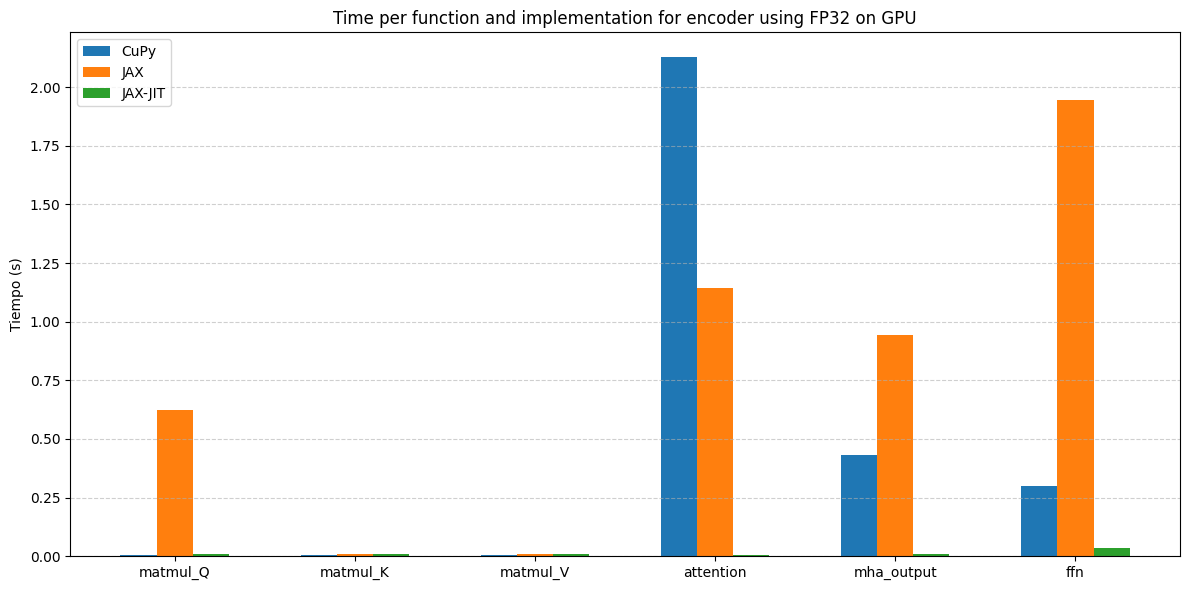

In [64]:


labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - 1*width, [results["CuPy"][l] for l in labels], width, label='CuPy')
ax.bar(x + 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Tiempo (s)')
ax.set_title('Time per function and implementation for encoder using FP32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

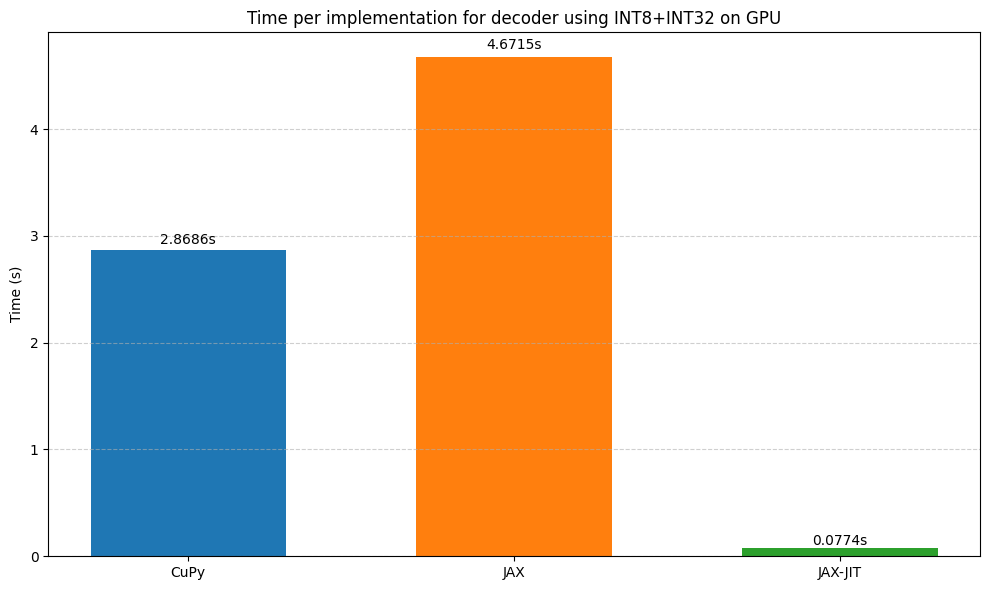

In [65]:

labels = ["CuPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Time per implementation for decoder using INT8+INT32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()



plt.show()

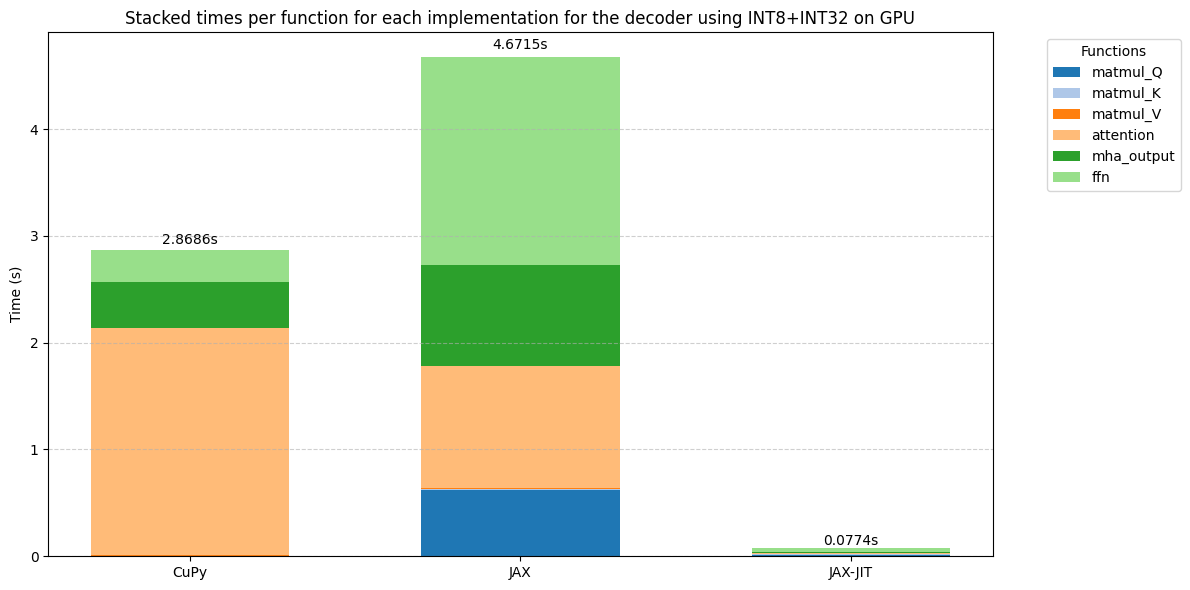

In [66]:

implementations = ["CuPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))


bottom = np.zeros(len(implementations))

for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')


ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the decoder using INT8+INT32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)

ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [67]:
df = pd.DataFrame(results).T

In [68]:
df

,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
CuPy,0.003415,0.003215,0.003291,2.127562,0.433273,0.297869,2.868624
JAX,0.621275,0.009481,0.009368,1.143366,0.943173,1.944819,4.671482
JIT-COMP,0.009225,0.008838,0.008967,0.742376,0.778775,0.931783,2.479966
JAX-JIT,0.008601,0.008600,0.008527,0.006718,0.008857,0.036113,0.077415
